In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math

#####

import json
import bisect
import itertools

import ephem
import datetime

from operator import attrgetter

from tvgutil import contact_plan as cp, tvg

with open("../scenario.json", "r") as f:
    scenario = json.load(f)
      
gs_list = scenario["gslist"]
sat_list = scenario["satlist"]

with open("../ftvg.json", "r") as f:
    ftvg = tvg.from_serializable(json.load(f))
    
fcp = tvg.to_contact_plan(ftvg)

print(f"Loaded scenario: {len(gs_list)} gs, {len(sat_list)} sat")
print(f"FCP has len = {len(fcp)}")
print(f"F-TVG has {len(ftvg.vertices)} vertices and {len(ftvg.edges)} edges")


class SatelliteTrajectoryPredictor:

    def __init__(self, sat_name, tle_list, gs_lat, gs_lon, gs_alt):
        self.sgp4_inst = {
            int(start_time): self._init_sgp4(
                sat_name,
                tle,
                gs_lat,
                gs_lon,
                gs_alt,
            )
            for start_time, tle in tle_list
        }
        self.sgp4_inst_keys = list(sorted(self.sgp4_inst.keys()))

    def _init_sgp4(self, sat_name, tle, gs_lat, gs_lon, gs_alt):
        sat = ephem.readtle(str(sat_name), *tle)
        obs = ephem.Observer()
        obs.lat = str(gs_lat)  # pylint: disable=assigning-non-slot
        obs.lon = str(gs_lon)  # pylint: disable=assigning-non-slot
        obs.elevation = int(gs_alt)  # pylint: disable=assigning-non-slot

        def _sgp4(time):
            obs.date = datetime.datetime.utcfromtimestamp(time)
            sat.compute(obs)
            return sat.alt, sat.az

        return _sgp4

    def _get_sgp4(self, time):
        try:
            return self.sgp4_inst[self.sgp4_inst_keys[
                bisect.bisect_right(self.sgp4_inst_keys, time)
            ]]
        except IndexError:
            return self.sgp4_inst[self.sgp4_inst_keys[-1]]

    def predict_elevation(self, time):
        sgp4 = self._get_sgp4(time)
        alt, _ = sgp4(time)
        return alt

    def predict_azimuth(self, time):
        sgp4 = self._get_sgp4(time)
        _, az = sgp4(time)
        return az


trajectory_predictors = {
        frozenset((gs["id"], sat["id"])): SatelliteTrajectoryPredictor(
            sat["id"],
            sat["tle_list"],
            gs["lat"],
            gs["lon"],
            gs["alt"],
        )
        for gs, sat in itertools.product(gs_list, sat_list)
}

Loaded scenario: 2 gs, 3 sat
FCP has len = 214
F-TVG has 5 vertices and 12 edges


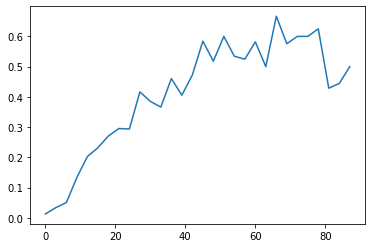

In [2]:
def get_decodability_histogram(fcp_cur, elevation_granularity=3, ber_threshold=1e-6, az_filter=None):
    elevation_range = list(range(0, 90, elevation_granularity))
    ber_bucks = np.array([0. for _ in elevation_range])
    all_bucks = np.array([0. for _ in elevation_range])
    for fc in fcp_cur:
        tp = trajectory_predictors[frozenset((fc.tx_node, fc.rx_node))]
        for i, char in enumerate(fc.characteristics):
            char_start = max(fc.start_time, char.starting_at)
            char_end = fc.characteristics[i + 1].starting_at if i + 1 < len(fc.characteristics) else fc.end_time
            if char_end <= char_start:
                continue
            char_mean = 0.5 * (char_start + char_end)
            char_duration_sec = char_end - char_start
            elev = tp.predict_elevation(char_mean) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char_mean) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            if char.bit_error_rate <= ber_threshold:
                ber_bucks[int(elev / elevation_granularity)] += char_duration_sec
            all_bucks[int(elev / elevation_granularity)] += char_duration_sec
    return elevation_range, ber_bucks, all_bucks

# Ratio that can be successfully decoded -- over all
elev, ber_bucks, all_bucks = get_decodability_histogram(fcp)
plt.plot(elev, ber_bucks / all_bucks)

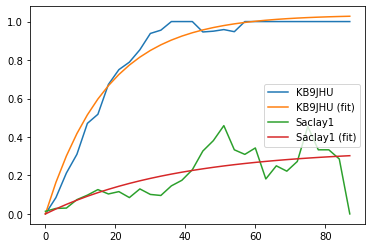

In [3]:
# overall GS quality evaluation

# NOTE: function seems to be roughly: a * (1 - exp(-b * x))
# ...with the asymptote a in [0; 1] and the scaling/rise factor b > 0

import scipy.optimize

def fit_fun(e, a, b):
    return a * (1 - np.exp(-b * e))

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, ber_bucks, all_bucks = get_decodability_histogram(p)
    plt.plot(elev, ber_bucks / all_bucks, label=gs["id"])
    res = scipy.optimize.curve_fit(fit_fun, elev, ber_bucks / all_bucks)
    plt.plot(elev, [fit_fun(e, res[0][0], res[0][1]) for e in elev], label=(gs["id"] + " (fit)"))
plt.legend()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


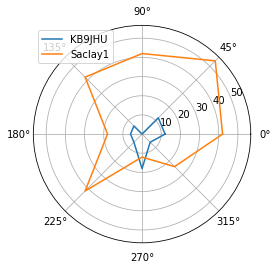

In [4]:
# determine minimum elevation

dh = {}
az_granularity = 45
elev_granularity = 6

ber_thresh = 1e-5
# 20 % of the time the BER should be below the threshold
min_ratio = 0.2

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    dh[gs["id"]] = []
    for az in range(0, 360, az_granularity):
        elev, ber_bucks, all_bucks = get_decodability_histogram(
            p,
            ber_threshold=ber_thresh,
            elevation_granularity=elev_granularity,
            az_filter=(az, az + az_granularity)
        )
        dh[gs["id"]].append(ber_bucks / all_bucks)

dh2 = {
    k: [(az_granularity * i, elev[np.argwhere(arr > min_ratio)[0][0]]) for i, arr in enumerate(v)]
    for k, v in dh.items()
}

for gs, vals in dh2.items():
    plt.polar(
        [x[0] / 180 * math.pi for x in vals] + [vals[0][0]],
        [x[1] for x in vals] + [vals[0][1]],
        label=gs
    )
plt.legend()

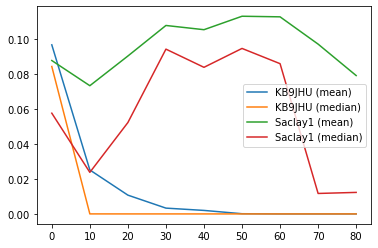

In [5]:
def get_mean_ber(fcp_cur, elevation_granularity=3, az_filter=None):
    elevation_range = list(range(0, 90, elevation_granularity))
    ber_bucks = [[] for _ in elevation_range]
    for fc in fcp_cur:
        tp = trajectory_predictors[frozenset((fc.tx_node, fc.rx_node))]
        for char in fc.characteristics:
            elev = tp.predict_elevation(char.starting_at) / math.pi * 180
            if az_filter:
                az = tp.predict_azimuth(char.starting_at) / math.pi * 180
                if az < az_filter[0] or az >= az_filter[1]:
                    continue
            ber_bucks[int(elev / elevation_granularity)].append(char.bit_error_rate)
    return elevation_range, ber_bucks

for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, bucks = get_mean_ber(p, 10)
    plt.plot(elev, [np.mean(x) for x in bucks], label=(gs["id"] + " (mean)"))
    plt.plot(elev, [np.median(x) for x in bucks], label=(gs["id"] + " (median)"))
    
plt.legend()

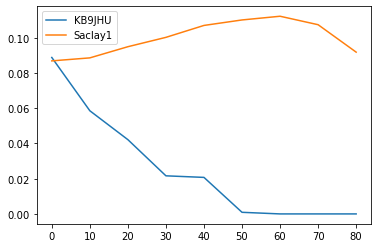

In [6]:
for gs in gs_list:
    p = ftvg.edges[(gs["id"], "NOAA 15")] + ftvg.edges[(gs["id"], "NOAA 18")] + ftvg.edges[(gs["id"], "NOAA 19")]
    elev, bucks = get_mean_ber(p, 10)
    plt.plot(elev, [np.std(x) for x in bucks], label=gs["id"])
    
plt.legend()

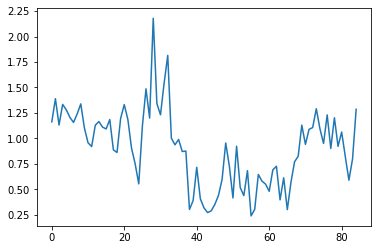

In [7]:
# test of inverting the SNR relationship
# NOTE: does not work if using ber after coding...

import scipy.special

def _ber_to_ebn0_bfsk(ber):
    # ber for bfsk: 1/2erfc(sqrt(eb/2n0))
    # see: https://www.atlantarf.com/FSK_Modulation.php
    return min(60, 2 * (scipy.special.erfcinv(2 * ber) ** 2))

plt.plot([_ber_to_ebn0_bfsk(c.bit_error_rate) for c in fcp[37].characteristics])